In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage

In [2]:
# name = "T_S04856"
name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [3]:
clusters = 10

In [4]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [5]:
def imshow(img: np.ndarray, color_channel="rgb"):
    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

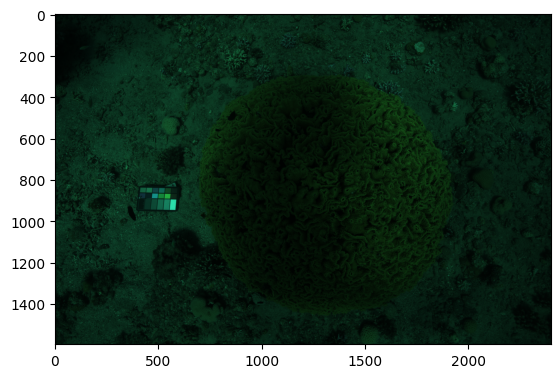

In [6]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [7]:
png.dtype

dtype('float64')

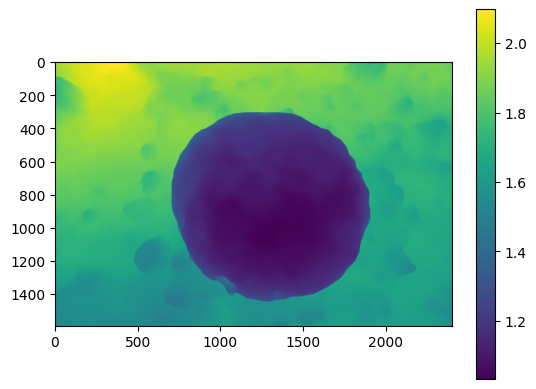

In [8]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [9]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [10]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [11]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

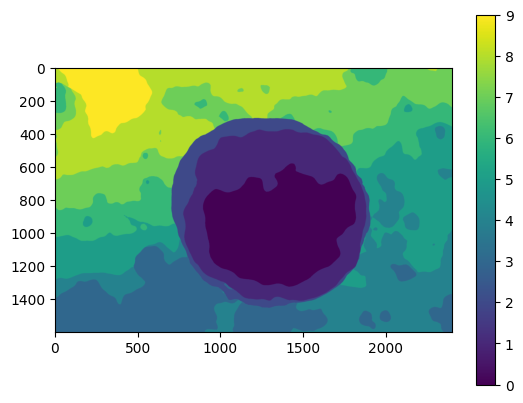

In [12]:
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
labels = np.zeros(tif_flat.shape, dtype=np.uint8)
labels[tif_flat != 0] = kmeans.labels_
labels[tif_flat == 0] = 255 # Use 255 to represent nan
means = np.array(kmeans.cluster_centers_).flatten()
means_args = np.argsort(means)

labels_new = np.zeros_like(labels)
labels_new[labels == 255] = clusters + 1

for current_label in range(clusters):
    new_label = np.nonzero(means_args == current_label)[0]
    labels_new[labels == current_label] = new_label

labels = labels_new.reshape((height, width))
imshow(labels)

In [13]:
dark_pixels = []
z_values = []

for i in range(clusters):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [14]:
dark_pixels.shape, z_values.shape

((48789, 3), (48789,))

In [15]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [16]:
z_values

array([1.11736989, 1.11718369, 1.11463082, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(48789,))

In [17]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [18]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return np.sum((B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)) ** 2)

In [19]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 0], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
b_args = result.x

b_args

array([5.62685480e-01, 1.34526385e-02, 4.49971324e-14, 5.00000000e+00])

In [20]:
optimize_estimate_backscatter(b_args, dark_pixels[:, 0], z_values)

np.float64(0.7324503388110648)

In [21]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 1], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
g_args = result.x

g_args

array([0.76810646, 0.01616228, 0.        , 2.5857675 ])

In [22]:
optimize_estimate_backscatter(g_args, dark_pixels[:, 1], z_values)

np.float64(1.0677418375524539)

In [23]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 2], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
r_args = result.x

r_args

array([1.81550604e-01, 8.68709536e-03, 1.69371646e-15, 5.00000000e+00])

In [24]:
optimize_estimate_backscatter(r_args, dark_pixels[:, 2], z_values)

np.float64(0.13036556095905305)

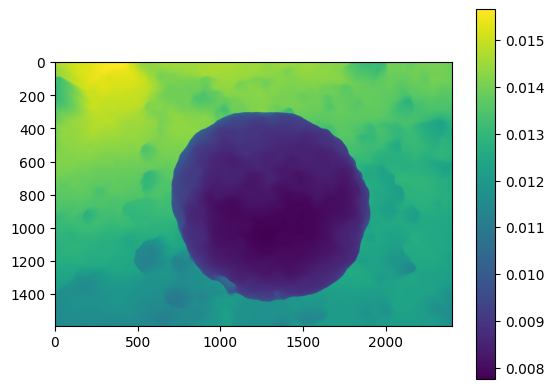

In [25]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

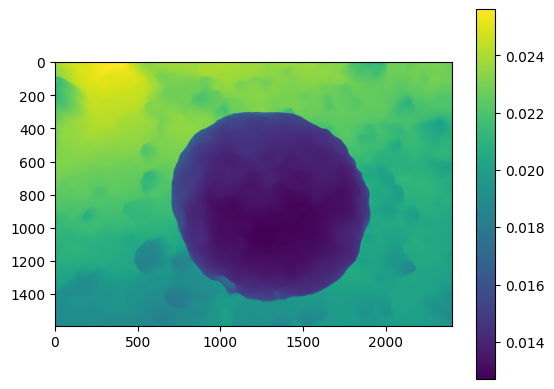

In [26]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

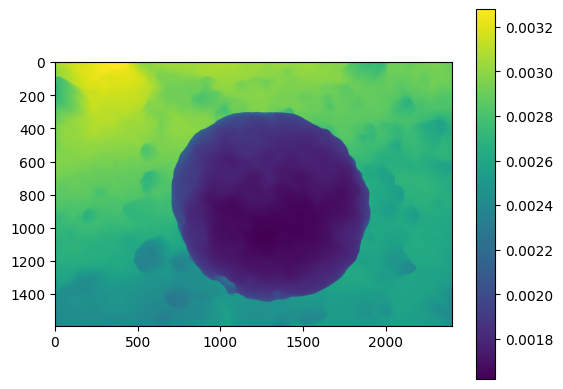

In [27]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

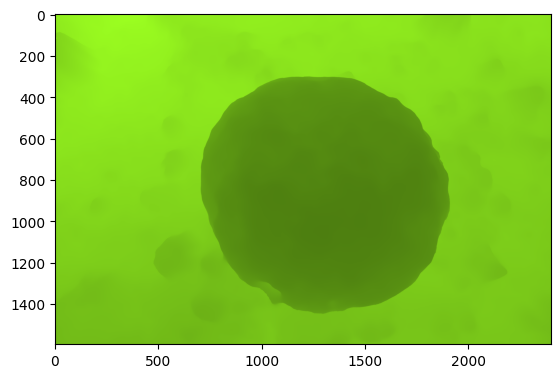

In [28]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

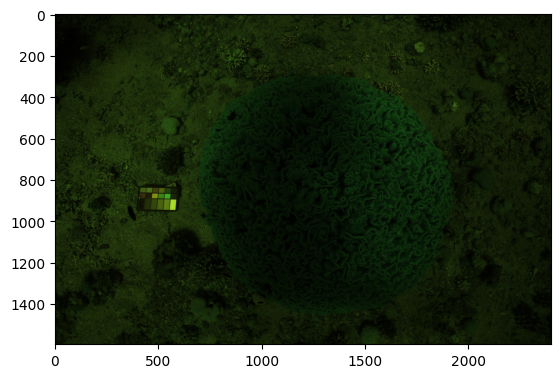

In [29]:
direct_signal = png - backscatter

sig_min_b = direct_signal[:, :, 0].min()
sig_min_g = direct_signal[:, :, 1].min()
sig_min_r = direct_signal[:, :, 2].min()

if sig_min_b > 0:
    sig_min_b = 0

if sig_min_g > 0:
    sig_min_g = 0

if sig_min_r > 0:
    sig_min_r = 0

direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

plt.imshow(direct_signal)

In [30]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [31]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0

In [32]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [33]:
import collections

def construct_neighborhood_map(depths, epsilon=0.05):
    eps = epsilon
    nmap = np.zeros_like(depths).astype(np.int32)
    n_neighborhoods = 1
    while np.any(nmap == 0):
        locs_x, locs_y = np.where(nmap == 0)
        start_index = np.random.randint(0, len(locs_x))
        start_x, start_y = locs_x[start_index], locs_y[start_index]
        q = collections.deque()
        q.append((start_x, start_y))
        while not len(q) == 0:
            x, y = q.pop()
            if np.abs(depths[x, y] - depths[start_x, start_y]) <= eps:
                nmap[x, y] = n_neighborhoods
                if 0 <= x < depths.shape[0] - 1:
                    x2, y2 = x + 1, y
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 1 <= x < depths.shape[0]:
                    x2, y2 = x - 1, y
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 0 <= y < depths.shape[1] - 1:
                    x2, y2 = x, y + 1
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
                if 1 <= y < depths.shape[1]:
                    x2, y2 = x, y - 1
                    if nmap[x2, y2] == 0:
                        q.append((x2, y2))
        n_neighborhoods += 1
    zeros_size_arr = sorted(
        zip(*np.unique(nmap[depths == 0], return_counts=True)),
        key=lambda x: x[1],
        reverse=True,
    )
    if len(zeros_size_arr) > 0:
        nmap[nmap == zeros_size_arr[0][0]] = 0  # reset largest background to 0
    return nmap, n_neighborhoods - 1


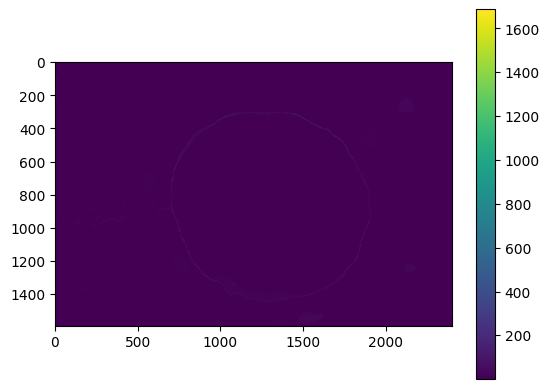

In [34]:
neighborhoods, _ = construct_neighborhood_map(tif, epsilon=epsilon)

imshow(neighborhoods)

In [35]:
# neighborhoods2 = np.load("./neighborhood_map.npz")["neighborhood_map"]
# # neighborhoods2[neighborhoods2 > 500] = 0

# imshow(neighborhoods2)

In [36]:
def update_a_prime(a_values: np.ndarray, neighborhood_map:np.ndarray):
    max_class = neighborhood_map.max()

    a_prime = np.zeros_like(a_values)
    for i in range(1, max_class + 1):
        selected_cells = neighborhood_map == i
        if not np.any(selected_cells):
            continue

        a_prime[selected_cells, 0] = a_values[selected_cells, 0].mean()
        a_prime[selected_cells, 1] = a_values[selected_cells, 1].mean()
        a_prime[selected_cells, 2] = a_values[selected_cells, 2].mean()

    return a_prime

def update_a_values(D: np.ndarray, a_prime: np.ndarray, p: float = 0.1):
    return D * p + a_prime * (1 - p)

In [ ]:
a_values = np.zeros((height, width, 3), dtype=np.float64) # We have more than one class than the total count b/c we did not use 0
prev_a_values = np.ones_like(a_values)

while np.any(np.abs(a_values - prev_a_values) >= convergence_threshold):
    print(np.abs(a_values - prev_a_values).max())

    prev_a_values = a_values

    a_prime = update_a_prime(a_values, neighborhoods)
    a_values = update_a_values(direct_signal, a_prime)

1.0
0.08811904798736915
0.0333999249536271
0.030059932458264382
0.027053939212437955
0.02434854529119415
0.02191369076207475
0.019722321685867267
0.01775008951728055
0.015975080565552496
0.014377572508997238
0.012939815258097481
0.011645833732287725
0.010481250359059002
0.009433125323153102
0.00848981279083777
0.007640831511753987
0.006876748360578555
0.0061890735245207495
0.005570166172068625
0.005013149554861762
0.004511834599375597
0.004060651139438043
0.003654586025494233
0.0032891274229448486


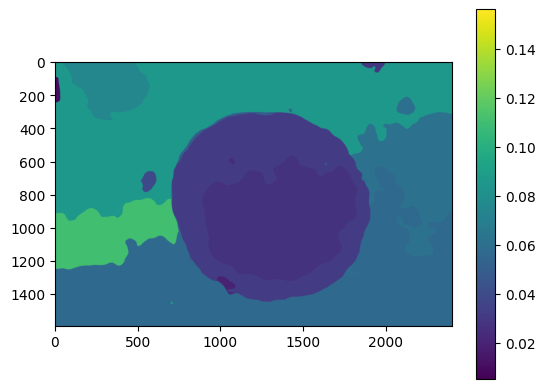

In [38]:
imshow(a_prime[:, :, 0])

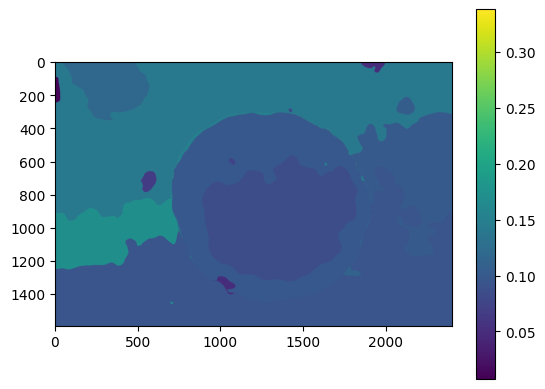

In [39]:
imshow(a_prime[:, :, 1])

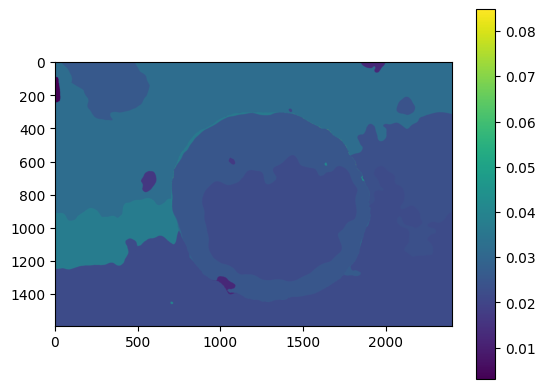

In [40]:
imshow(a_prime[:, :, 2])

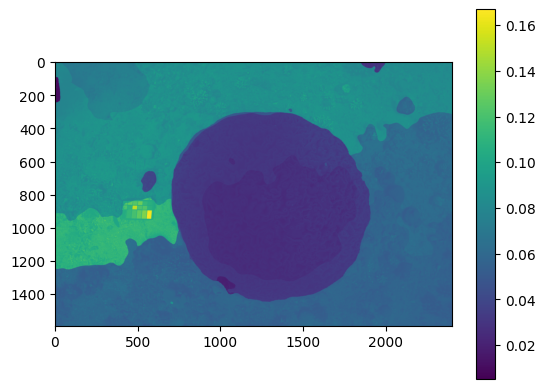

In [41]:
imshow(a_values[:, :, 0])

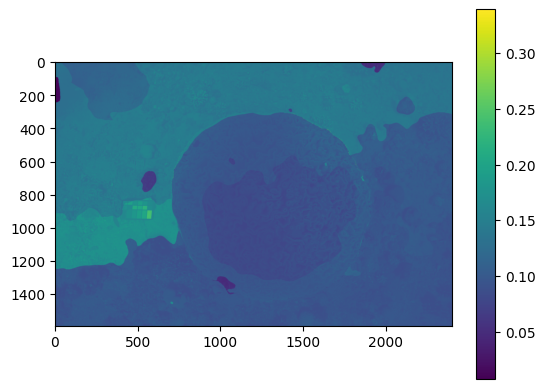

In [42]:
imshow(a_values[:, :, 1])

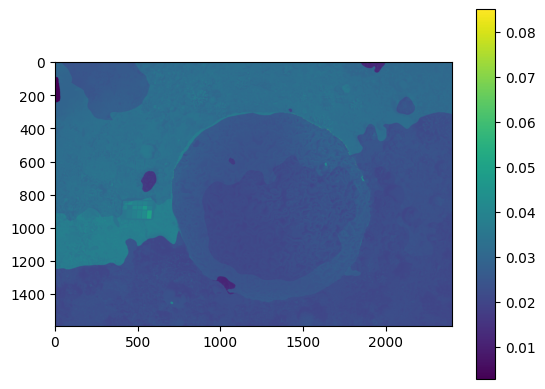

In [43]:
imshow(a_values[:, :, 2])

0.6788010320531357


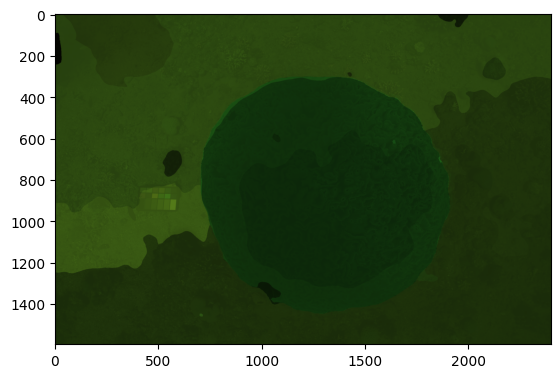

In [44]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map)

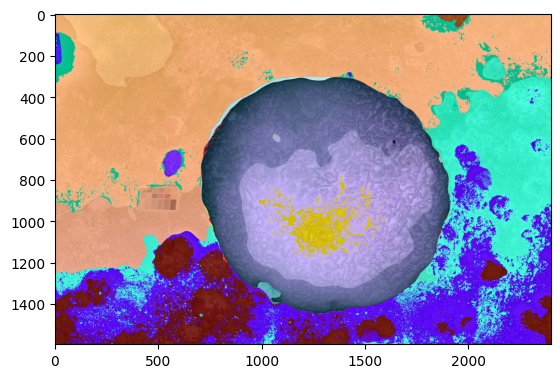

In [45]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

imshow(beta_d_coarse)

### Refined Estimate of $\beta_c^D(z)$

In [46]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [47]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> float:
    a, b, c, d = args
    return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)

In [48]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 0], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_b = result.x

local_illuminant_params_b

/tmp/ipykernel_303697/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


array([45.67185019, -5.27848859, 45.67185019, -5.27848859])

In [49]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 1], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_g = result.x

local_illuminant_params_g

/tmp/ipykernel_303697/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)


array([46.15770761, -4.89776525, 46.15770761, -4.89776525])

In [50]:
result = minimize(optimize_compute_beta_D, [100, -100, 100, -100], args=(local_illuminant_map[:, :, 2], tif), bounds=[(0,None), (None,0), (0,None), (None,0)])
local_illuminant_params_r = result.x

local_illuminant_params_r

/tmp/ipykernel_303697/3012957830.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sum((z - np.log(E / compute_beta_D(a, b, c, d, z))) ** 2)


array([53.52114922, -5.83300452, 53.52114922, -5.83300452])

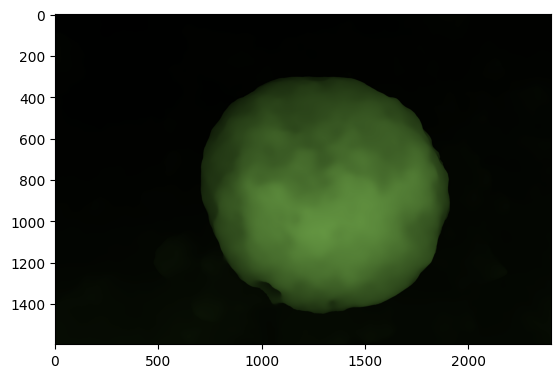

In [51]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

imshow(beta_d)

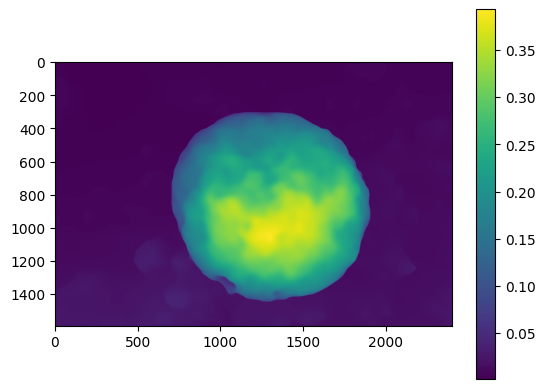

In [52]:
imshow(beta_d[:, :, 0])

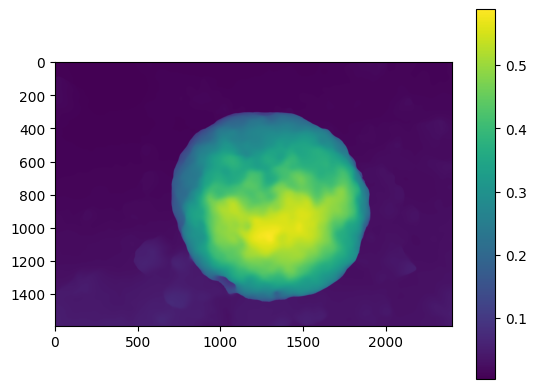

In [53]:
imshow(beta_d[:, :, 1])

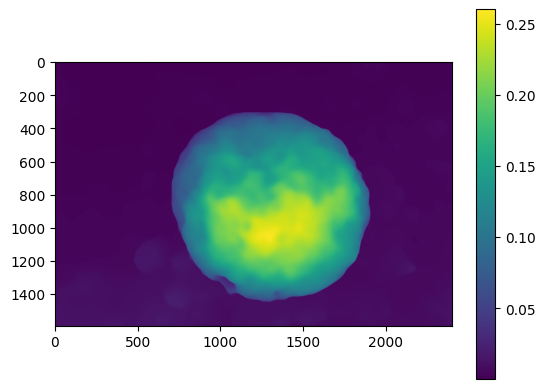

In [54]:
imshow(beta_d[:, :, 2])

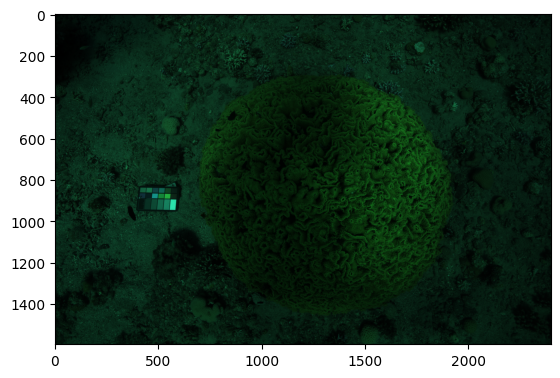

In [55]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

imshow(J, color_channel="bgr")

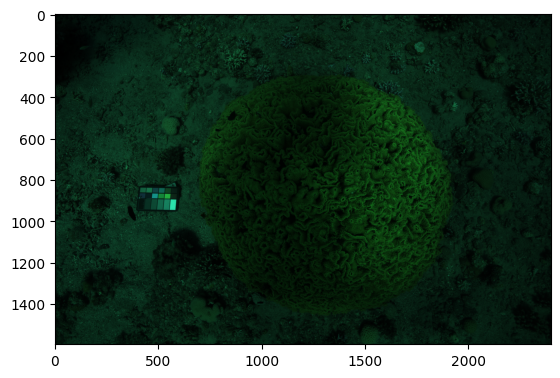

In [56]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [57]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [58]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

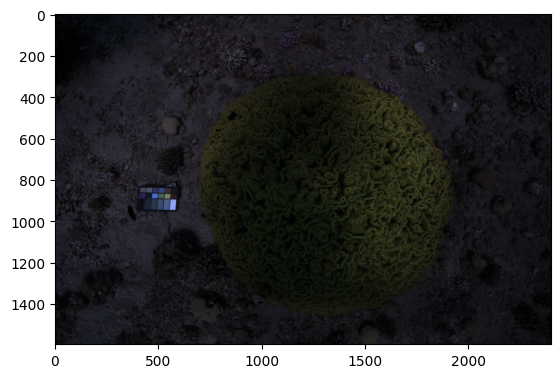

In [59]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [60]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

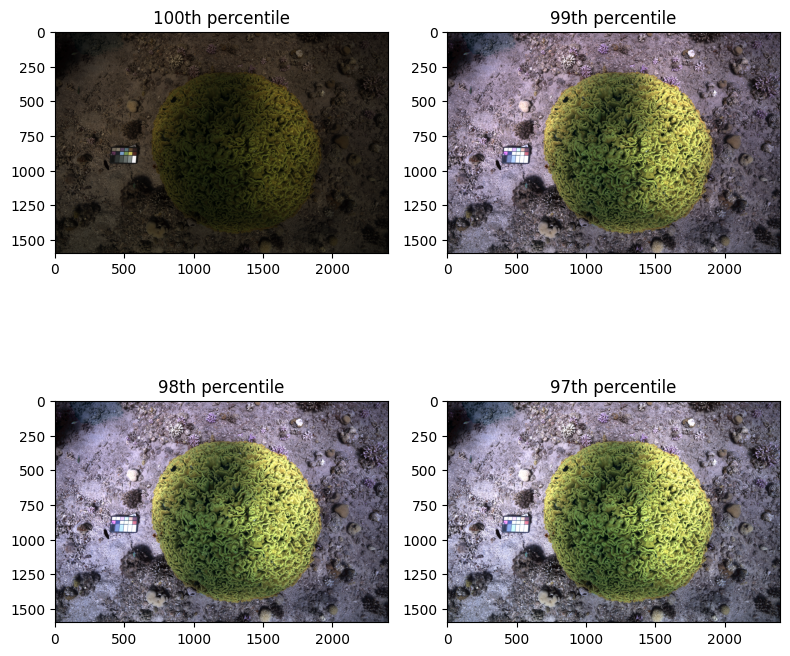

In [61]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

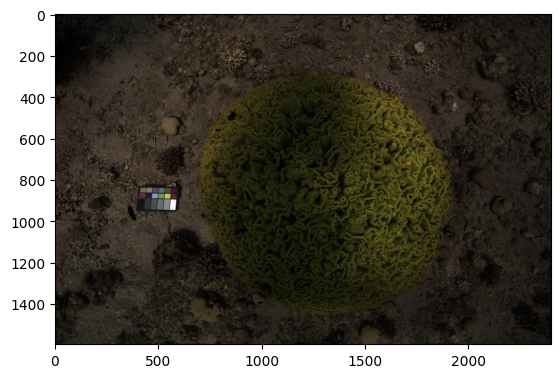

In [62]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

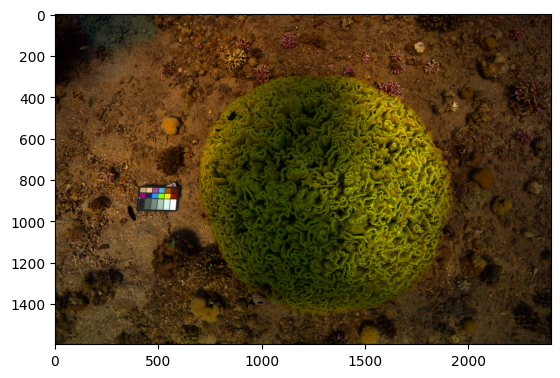

In [69]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

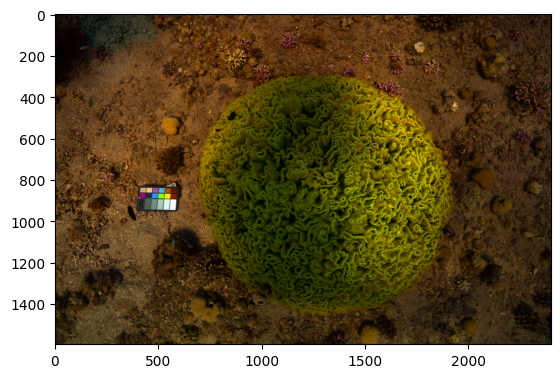

In [70]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

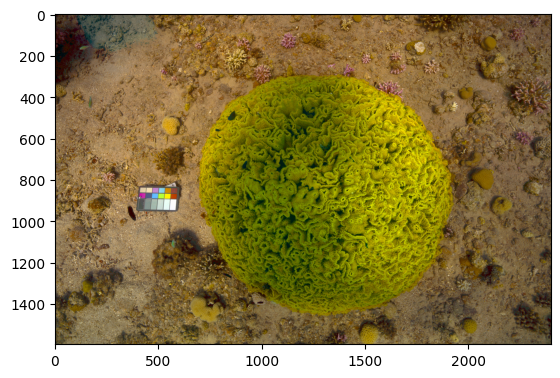

In [65]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

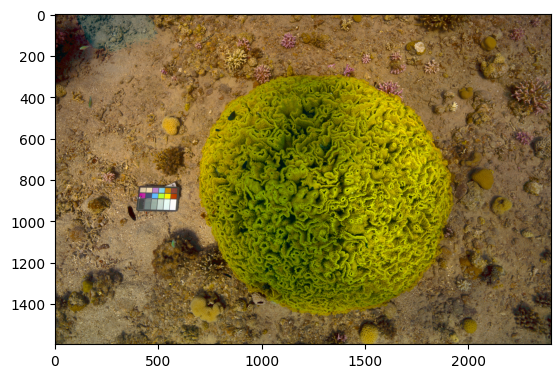

In [66]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [68]:
cv2.imwrite("output/crutchfield2_final.png", img_as_ubyte(img_hist))

True